In [1]:
%config Completer.use_jedi = False

In [2]:
import pandas as pd
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

In [3]:
datos = pd.read_csv('datos.csv')

In [4]:
datos.head()

,colonia,alcaldia,bimestre,consumo_total,idh
0,1A. AMPLIACION PRESIDENTES,ALVARO OBREGON,1,2968.52,0.836
1,1A. AMPLIACION PRESIDENTES,ALVARO OBREGON,2,3092.45,0.836
2,1A. AMPLIACION PRESIDENTES,ALVARO OBREGON,3,3114.91,0.836
3,1A. VICTORIA,ALVARO OBREGON,1,11249.78,0.836
4,1A. VICTORIA,ALVARO OBREGON,2,11768.77,0.836


In [5]:
datos.dtypes

colonia           object
alcaldia          object
bimestre           int64
consumo_total    float64
idh              float64
dtype: object

In [6]:
X = datos.drop(columns=['consumo_total', 'colonia'])

In [7]:
y = datos['consumo_total']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123)

In [9]:
nom_cols = X_train.select_dtypes(include=['object', 'int64']).columns.to_list()

In [10]:
preprocessor_nom = ColumnTransformer(transformers=[('OneHot',
                                                    OneHotEncoder(handle_unknown='ignore', sparse=False),
                                                    nom_cols)])

In [11]:
X_train_prep = preprocessor_nom.fit_transform(X_train)
X_test_prep = preprocessor_nom.fit_transform(X_test)

In [12]:
col_names_nom = preprocessor_nom.named_transformers_['OneHot'].get_feature_names(nom_cols)

In [13]:
X_train_prep_df = pd.DataFrame(data=X_train_prep, columns=col_names_nom)
X_test_prep_df = pd.DataFrame(data=X_test_prep, columns=col_names_nom)

In [14]:
X_train_prep_df = X_train_prep_df.assign(IDH = X_train['idh'].tolist())
X_test_prep_df = X_test_prep_df.assign(IDH = X_test['idh'].tolist())

In [15]:
param_grid = {'n_estimators': [100, 150, 300, 500],
              'max_features': [5, 10, 15, 20],
              'max_depth'   : [None, 3, 10, 20, 50]
             }

grid = GridSearchCV(
        estimator  = RandomForestRegressor(random_state = 123),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train_prep_df, y = y_train)

resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
25,3,15,150,-50357.273488,6014.624194,-49313.758352,1526.986028
26,3,15,300,-50357.416026,6000.631506,-49305.109605,1526.427857
24,3,15,100,-50373.807286,6019.271238,-49336.124365,1525.199748
27,3,15,500,-50383.780306,6010.880642,-49305.681019,1524.663527


In [16]:
print("Mejores hiperparámetros encontrados usando validación cruzada")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

Mejores hiperparámetros encontrados usando validación cruzada
{'max_depth': 3, 'max_features': 15, 'n_estimators': 150} : -50357.27348780452 neg_root_mean_squared_error


In [17]:
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test_prep_df)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"La raíz del error cuadrático medio para los datos de prueba: {rmse}")

La raíz del error cuadrático medio para los datos de prueba: 63990.41432656632


In [18]:
perm_importance = permutation_importance(modelo_final, X_test_prep_df, y_test)

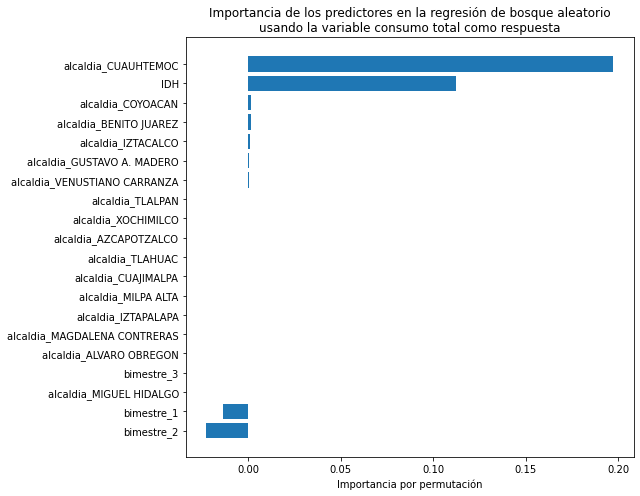

In [19]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(9,7))
plt.barh(X_train_prep_df.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Importancia por permutación")
plt.title("Importancia de los predictores en la regresión de bosque aleatorio\nusando la variable consumo total como respuesta")
plt.tight_layout()
plt.savefig("ImportanciaPredictores.pdf")
plt.show()